In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns

# Import Data
### Here there are some additional function to read better the files

In [2]:
def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df


def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            if not (type(df[col][0])==list):
                num_unique_values = len(df[col].unique())
                num_total_values = len(df[col])
                if float(num_unique_values) / num_total_values < 0.5:
                    df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df

def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))


def optimized_merge(df1, df2, merge_column):
    df2 = df2[df2[merge_column].isin(df1[merge_column])]
    return df1.merge(df2, on=merge_column)

In [3]:
df1 = pd.read_csv("data_raw/movies.csv").astype({"movieId": "int64", 
                                                 "title": "str", 
                                                 "genres": "str"})

df2 = pd.read_csv("data_raw/ratings.csv").astype({"userId": "int64", 
                                                  "movieId": "int64", 
                                                  "rating": "float", 
                                                  "timestamp": "datetime64[s]"})

df3 = pd.read_csv("data_raw/tags.csv").astype({"userId": "int64", 
                                               "movieId": "int64", 
                                               "tag": "str", 
                                               "timestamp": "datetime64[s]"})

### Here the second dataframe contains wrong data
### This year means the year when the movie was scored

In [5]:
# This computation is not neccessary
#df2['year_scored'] = df2['timestamp'].dt.strftime('%Y')
#df3['year_scored'] = df3['timestamp'].dt.strftime('%Y')

In [4]:
df4 = optimized_merge(df2, df1, 'movieId').replace({None: pd.NA}).convert_dtypes()
df4.shape
df4.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres'], dtype='object')

In [5]:
df5 = optimized_merge(df1, df3, 'movieId').replace({None: pd.NA}).convert_dtypes()
df5.shape
df5.columns

Index(['movieId', 'title', 'genres', 'userId', 'tag', 'timestamp'], dtype='object')

### We need to create the year when the movie was released, not about when it was scored 

In [6]:
df4['year'] = df4['title'].str[-5:].str[:4]
df5['year'] = df5['title'].str[-5:].str[:4]

In [7]:
df4['title'] = df4['title'].str[:-7]
df5['title'] = df5['title'].str[:-7]

In [8]:
df4

,userId,movieId,rating,timestamp,title,genres,year
0,1,296,5.0,2006-05-17 15:34:04,Pulp Fiction,Comedy|Crime|Drama|Thriller,1994
1,3,296,5.0,2015-08-13 14:01:16,Pulp Fiction,Comedy|Crime|Drama|Thriller,1994
2,4,296,4.0,2019-11-16 21:14:58,Pulp Fiction,Comedy|Crime|Drama|Thriller,1994
3,5,296,4.0,1996-04-29 13:55:55,Pulp Fiction,Comedy|Crime|Drama|Thriller,1994
4,7,296,4.0,1996-06-22 11:58:50,Pulp Fiction,Comedy|Crime|Drama|Thriller,1994
...,...,...,...,...,...,...,...
25000090,162358,200192,2.0,2019-03-24 18:43:59,Den frusna leoparden,(no genres listed),1986
25000091,162358,200194,2.0,2019-03-24 18:57:23,Tough Luck,Action|Adventure|Thriller,2004
25000092,162386,139970,3.5,2019-02-03 17:46:05,I Don't Speak English,Comedy,1995
25000093,162386,200726,4.0,2019-04-07 15:36:57,The Graduates,Children|Drama,1995


In [9]:
df4['title'].value_counts().nlargest(10)

title
Forrest Gump                          81491
Shawshank Redemption, The             81482
Pulp Fiction                          79672
Silence of the Lambs, The             74127
Matrix, The                           72674
Star Wars: Episode IV - A New Hope    68717
Jurassic Park                         64144
Schindler's List                      60411
Braveheart                            59184
Fight Club                            58773
Name: count, dtype: Int64

In [10]:
df4['year'] = pd.to_numeric(df4['year'], errors="coerce")

In [11]:
df4.dropna(how="any", inplace=True)

In [12]:
df_gruped1 = df4.groupby(['year', 'title']).size().reset_index(name='counts')

In [13]:
df_gtop10 = df_gruped1.sort_values('counts')\
            .drop_duplicates(['year'], keep='last')\
            .nlargest(n=10, columns=['counts'])
df_gtop10

,year,title,counts
21999,1994,Forrest Gump,81491
20622,1991,"Silence of the Lambs, The",74127
25709,1999,"Matrix, The",72674
13907,1977,Star Wars: Episode IV - A New Hope,68717
21506,1993,Jurassic Park,64144
22513,1995,Braveheart,59184
15208,1980,Star Wars: Episode V - The Empire Strikes Back,57361
27472,2001,"Lord of the Rings: The Fellowship of the Ring,...",55736
16485,1983,Star Wars: Episode VI - Return of the Jedi,54917
15618,1981,Raiders of the Lost Ark (Indiana Jones and the...,54675


Text(0.5, 0.98, 'Top 10 of movies of each year')

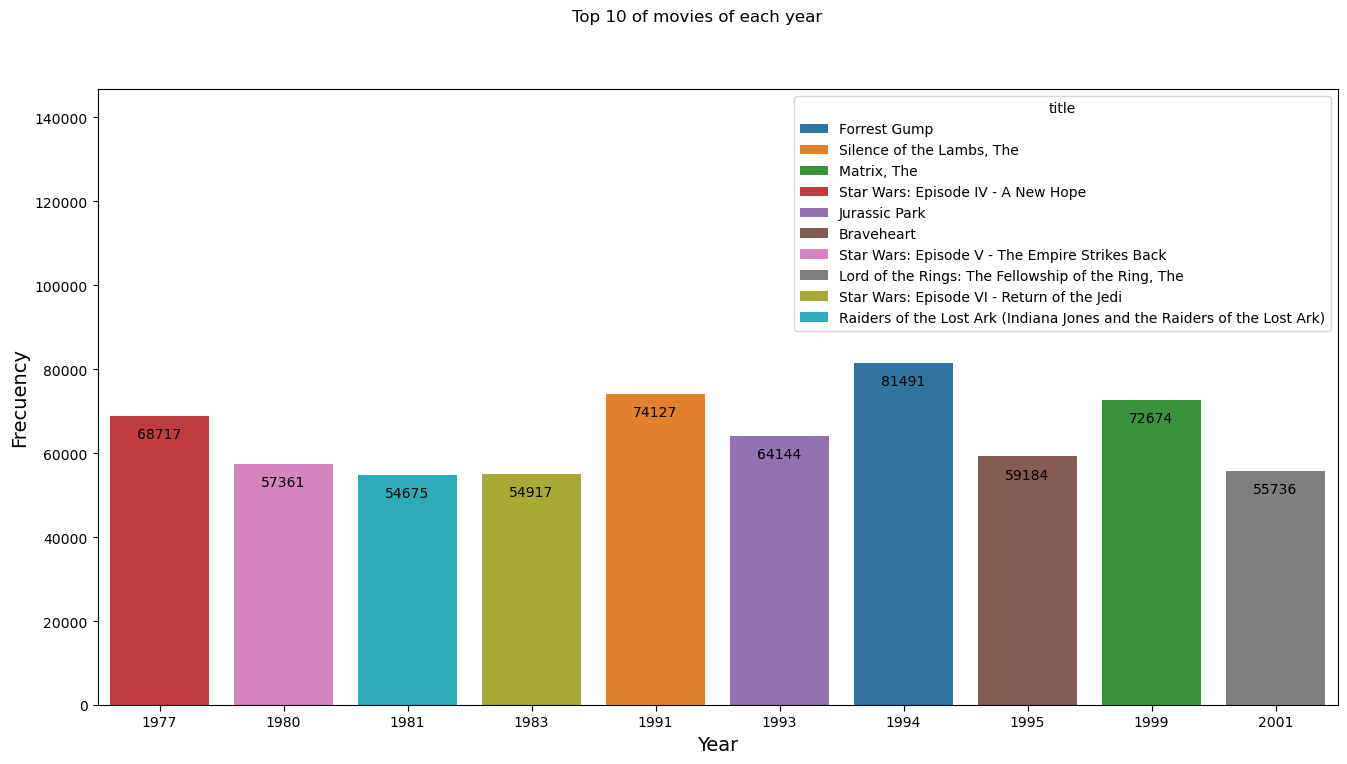

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize= (16, 8))
general_plot = sns.barplot(df_gtop10, x="year", y="counts", hue="title", dodge=False)

plt.ylim(-2, 81491*(1.8))

general_plot.tick_params(labelsize = 10)
general_plot.tick_params(length = 4, axis='x')

for g in general_plot.patches:
    general_plot.annotate(format(g.get_height(), 'g'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, -13),
                   textcoords = 'offset points')
    
    
plt.xlabel("Year", size = 14)
plt.ylabel("Frecuency", size = 14)
fig.suptitle('Top 10 of movies of each year')

In [15]:
df_gruped_rate = df4.groupby(['movieId','title', 'year'])['rating']\
                    .sum().reset_index()\
                    .sort_values('rating')\
                    .drop_duplicates(['year'], keep='last')
df_gruped_rate

,movieId,title,year,rating
44596,175335,The Garden of Afflictio,201,5.5
56153,202045,Athlete Swinging a Pick,1880,8.0
33675,148064,Newark Athlete,1891,25.0
44121,174185,The Dancing Pig,1907,27.0
33663,148040,Man Walking Around a Corner,1887,28.0
...,...,...,...,...
522,527,Schindler's List,1993,256600.5
257,260,Star Wars: Episode IV - A New Hope,1977,283127.0
2480,2571,"Matrix, The",1999,301895.0
585,593,"Silence of the Lambs, The",1991,307726.5


In [90]:
df_gtop10_r = df_gruped_rate.nlargest(n=10, columns=['rating']).reset_index()
df_gtop10_r['year'] = pd.to_numeric(df_gtop10_r['year'], errors="coerce")
df_gtop10_r['rating'] = df_gtop10_r['rating'].astype(int)
df_gtop10_r.dtypes

index               int64
movieId             Int64
title      string[python]
year                Int64
rating              int64
dtype: object

Text(0.5, 0.98, 'Top 10 of movies rated of each year')

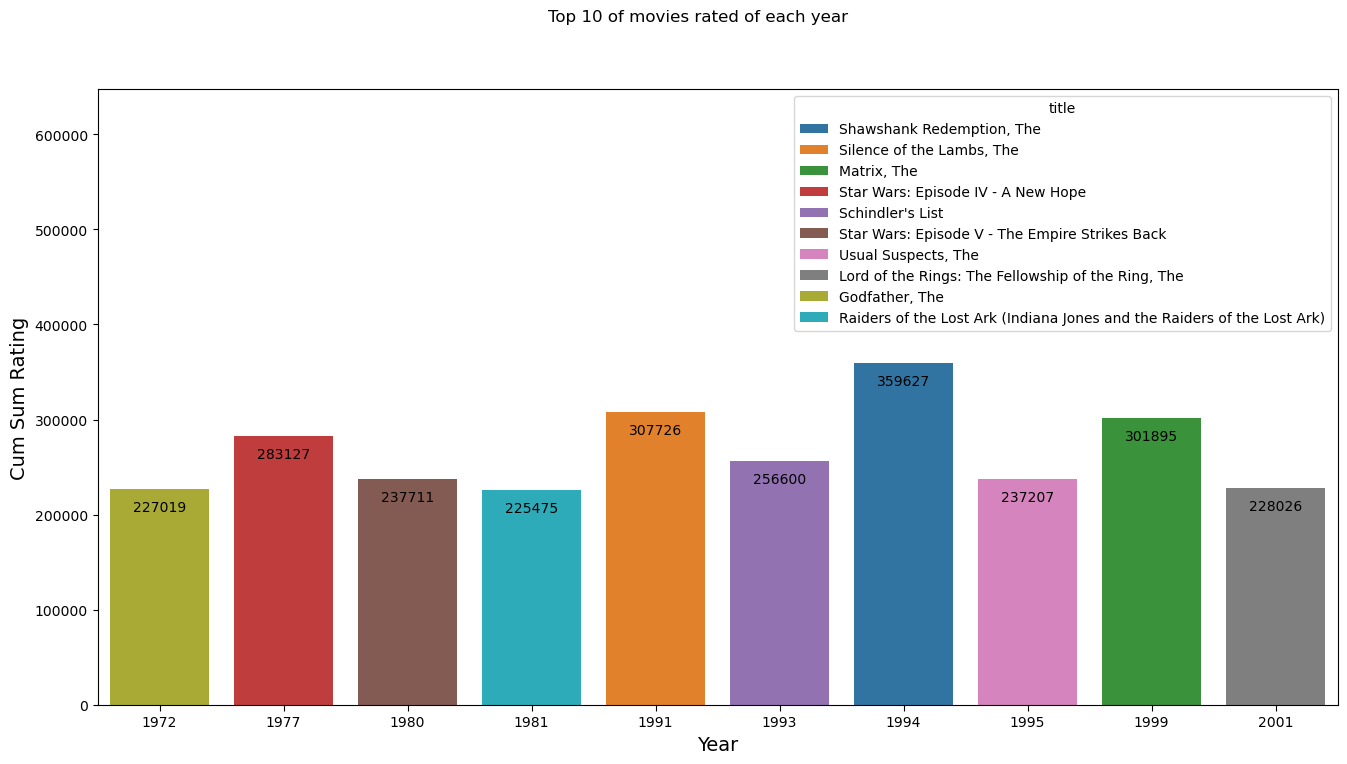

In [94]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize= (16, 8))
general_plot = sns.barplot(df_gtop10_r, x="year", y="rating", hue="title", dodge=False)

plt.ylim(-2, 359627*(1.8))

general_plot.tick_params(labelsize = 10)
general_plot.tick_params(length = 4, axis='x')

for g in general_plot.patches:
    general_plot.annotate(format(g.get_height(), 'g'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, -13),
                   textcoords = 'offset points')
    
    
plt.xlabel("Year", size = 14)
plt.ylabel("Cum Sum Rating", size = 14)
fig.suptitle('Top 10 of movies rated of each year')

## Analysis per Gender and Tag

In [21]:
df5

,movieId,title,genres,userId,tag,timestamp,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,791,Owned,2018-01-05 18:04:53,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1048,imdb top 250,2007-02-22 11:39:54,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1361,Pixar,2008-07-15 18:25:11,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,3164,Pixar,2008-10-06 14:52:07,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,3164,time travel,2008-10-06 14:52:09,1995
...,...,...,...,...,...,...,...
1093355,209063,The Prep School Negro,(no genres listed),96399,Philadelphia,2019-11-17 20:06:20,2012
1093356,209063,The Prep School Negro,(no genres listed),96399,private school,2019-11-17 20:05:58,2012
1093357,209063,The Prep School Negro,(no genres listed),96399,quaker,2019-11-17 20:06:37,2012
1093358,209063,The Prep School Negro,(no genres listed),96399,racism,2019-11-17 20:06:34,2012


In [22]:
df_exp = pd.concat(
    (df5.iloc[:, :-1], df5.genres.str.replace("\s+(?=\|)", "").str.get_dummies()),
    axis=1,
)

In [23]:
df_gen = pd.melt(df_exp, id_vars=['movieId', 'title', 'userId', 'tag'], 
                 value_vars=['(no genres listed)', 
                             'Action', 
                             'Adventure', 
                             'Animation', 
                             'Children',
                             'Comedy', 
                             'Crime', 
                             'Documentary', 
                             'Drama', 
                             'Fantasy', 
                             'Film-Noir',
                             'Horror', 
                             'IMAX', 
                             'Musical', 
                             'Mystery', 
                             'Romance', 
                             'Sci-Fi', 
                             'Thriller',
                             'War', 
                             'Western'], 
                 ignore_index=True)

In [24]:
df_10 = df_gen.groupby(["movieId", "title", "userId", "variable", 'tag']).sum().reset_index()

In [25]:
df_gruped_gen = df_10.groupby(["movieId", "variable"]).size().reset_index(name='counts')
df_gruped_tag = df_10.groupby(["movieId", 'tag']).size().reset_index(name='counts')

In [26]:
df_gruped_gen = df_gruped_gen.loc[lambda x: x['variable'] != "(no genres listed)"]

In [27]:
df_g2top10 = df_gruped_gen.sort_values('counts')\
            .drop_duplicates(['movieId'], keep='last')\
            .nlargest(n=15, columns=['counts'])

df_g2top10.rename(columns={"variable": "genre", "counts":"count_gen"}, inplace=True)

In [28]:
df_g2top10

,movieId,genre,count_gen
4961,260,Action,6180
284770,79132,Film-Noir,4767
5637,296,Thriller,4767
394366,109487,Crime,3616
54161,2959,Action,3612
6057,318,Thriller,3597
46714,2571,Mystery,3573
6791,356,Horror,2701
78218,4226,War,2601
138063,7361,Animation,2533


In [30]:
df_g3top10 = df_gruped_tag.sort_values('counts')\
    .drop_duplicates(['movieId'], keep='last')\
    .nlargest(n=15, columns=['counts'])

df_g3top10.rename(columns = {"variable": "tag", "counts":"count_tag"}, 
                  inplace=True)

In [31]:
df_g3top10

,movieId,tag,count_tag
7032,260,sci-fi,12960
8016,296,Quentin Tarantino,6080
273401,79132,alternate reality,5500
77458,2959,twist ending,5460
102937,4226,nonlinear,4900
68358,2571,sci-fi,4880
156005,7361,surreal,4500
2032,50,twist ending,4380
331708,109487,space,4060
343346,115713,artificial intelligence,3980


## Lets join the movie_id with the original year when the movie was released

In [42]:
df_final = pd.merge(df_g2top10, df_g3top10, on = "movieId")
df_final

,movieId,genre,count_gen,tag,count_tag
0,260,Action,6180,sci-fi,12960
1,79132,Film-Noir,4767,alternate reality,5500
2,296,Thriller,4767,Quentin Tarantino,6080
3,109487,Crime,3616,space,4060
4,2959,Action,3612,twist ending,5460
5,318,Thriller,3597,Morgan Freeman,3460
6,2571,Mystery,3573,sci-fi,4880
7,4226,War,2601,nonlinear,4900
8,7361,Animation,2533,surreal,4500
9,593,Thriller,2482,serial killer,3740


In [43]:
df_rig = df4[["movieId", "title", "year"]].loc[lambda x: x['movieId'].isin(df_final['movieId'])]
df_rig.drop_duplicates(['movieId', 'title', 'year'], keep='last')

,movieId,title,year
79671,296,Pulp Fiction,1994
562919,7361,Eternal Sunshine of the Spotless Mind,2004
875970,260,Star Wars: Episode IV - A New Hope,1977
982867,318,"Shawshank Redemption, The",1994
2780727,2571,"Matrix, The",1999
4331258,593,"Silence of the Lambs, The",1991
5179565,2959,Fight Club,1999
5628979,4226,Memento,2000
7122738,48780,"Prestige, The",2006
8051582,79132,Inception,2010


In [44]:
df_final = df_final.merge(df_rig, on='movieId', how='left')\
            .drop_duplicates(['movieId', 'title', 'year', 'genre', 'count_gen', 'tag','count_tag'], 
                            keep='last')

In [45]:
df_final

,movieId,genre,count_gen,tag,count_tag,title,year
68716,260,Action,6180,sci-fi,12960,Star Wars: Episode IV - A New Hope,1977
107611,79132,Film-Noir,4767,alternate reality,5500,Inception,2010
187283,296,Thriller,4767,Quentin Tarantino,6080,Pulp Fiction,1994
209917,109487,Crime,3616,space,4060,Interstellar,2014
268690,2959,Action,3612,twist ending,5460,Fight Club,1999
350172,318,Thriller,3597,Morgan Freeman,3460,"Shawshank Redemption, The",1994
422846,2571,Mystery,3573,sci-fi,4880,"Matrix, The",1999
464041,4226,War,2601,nonlinear,4900,Memento,2000
497266,7361,Animation,2533,surreal,4500,Eternal Sunshine of the Spotless Mind,2004
571393,593,Thriller,2482,serial killer,3740,"Silence of the Lambs, The",1991


In [46]:
df_a = df_final[["movieId", "genre", "count_gen", "title", "year"]]
df_a.rename(columns = {"genre": "class", "count_gen":"count"}, 
                  inplace=True)
df_a["type"] = "genre"
df_a

/tmp/ipykernel_38631/3198261084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a.rename(columns = {"genre": "class", "count_gen":"count"},
/tmp/ipykernel_38631/3198261084.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a["type"] = "genre"


,movieId,class,count,title,year,type
68716,260,Action,6180,Star Wars: Episode IV - A New Hope,1977,genre
107611,79132,Film-Noir,4767,Inception,2010,genre
187283,296,Thriller,4767,Pulp Fiction,1994,genre
209917,109487,Crime,3616,Interstellar,2014,genre
268690,2959,Action,3612,Fight Club,1999,genre
350172,318,Thriller,3597,"Shawshank Redemption, The",1994,genre
422846,2571,Mystery,3573,"Matrix, The",1999,genre
464041,4226,War,2601,Memento,2000,genre
497266,7361,Animation,2533,Eternal Sunshine of the Spotless Mind,2004,genre
571393,593,Thriller,2482,"Silence of the Lambs, The",1991,genre


In [47]:
df_b = df_final[["movieId", "tag", "count_tag", "title", "year"]]
df_b.rename(columns = {"tag": "class", "count_tag":"count"}, 
                  inplace=True)
df_b["type"] = "tag"
df_b

/tmp/ipykernel_38631/1965895596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b.rename(columns = {"tag": "class", "count_tag":"count"},
/tmp/ipykernel_38631/1965895596.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b["type"] = "tag"


,movieId,class,count,title,year,type
68716,260,sci-fi,12960,Star Wars: Episode IV - A New Hope,1977,tag
107611,79132,alternate reality,5500,Inception,2010,tag
187283,296,Quentin Tarantino,6080,Pulp Fiction,1994,tag
209917,109487,space,4060,Interstellar,2014,tag
268690,2959,twist ending,5460,Fight Club,1999,tag
350172,318,Morgan Freeman,3460,"Shawshank Redemption, The",1994,tag
422846,2571,sci-fi,4880,"Matrix, The",1999,tag
464041,4226,nonlinear,4900,Memento,2000,tag
497266,7361,surreal,4500,Eternal Sunshine of the Spotless Mind,2004,tag
571393,593,serial killer,3740,"Silence of the Lambs, The",1991,tag


In [48]:
df_gentag = pd.concat([df_a, df_b])
df_gentag

,movieId,class,count,title,year,type
68716,260,Action,6180,Star Wars: Episode IV - A New Hope,1977,genre
107611,79132,Film-Noir,4767,Inception,2010,genre
187283,296,Thriller,4767,Pulp Fiction,1994,genre
209917,109487,Crime,3616,Interstellar,2014,genre
268690,2959,Action,3612,Fight Club,1999,genre
350172,318,Thriller,3597,"Shawshank Redemption, The",1994,genre
422846,2571,Mystery,3573,"Matrix, The",1999,genre
464041,4226,War,2601,Memento,2000,genre
497266,7361,Animation,2533,Eternal Sunshine of the Spotless Mind,2004,genre
571393,593,Thriller,2482,"Silence of the Lambs, The",1991,genre


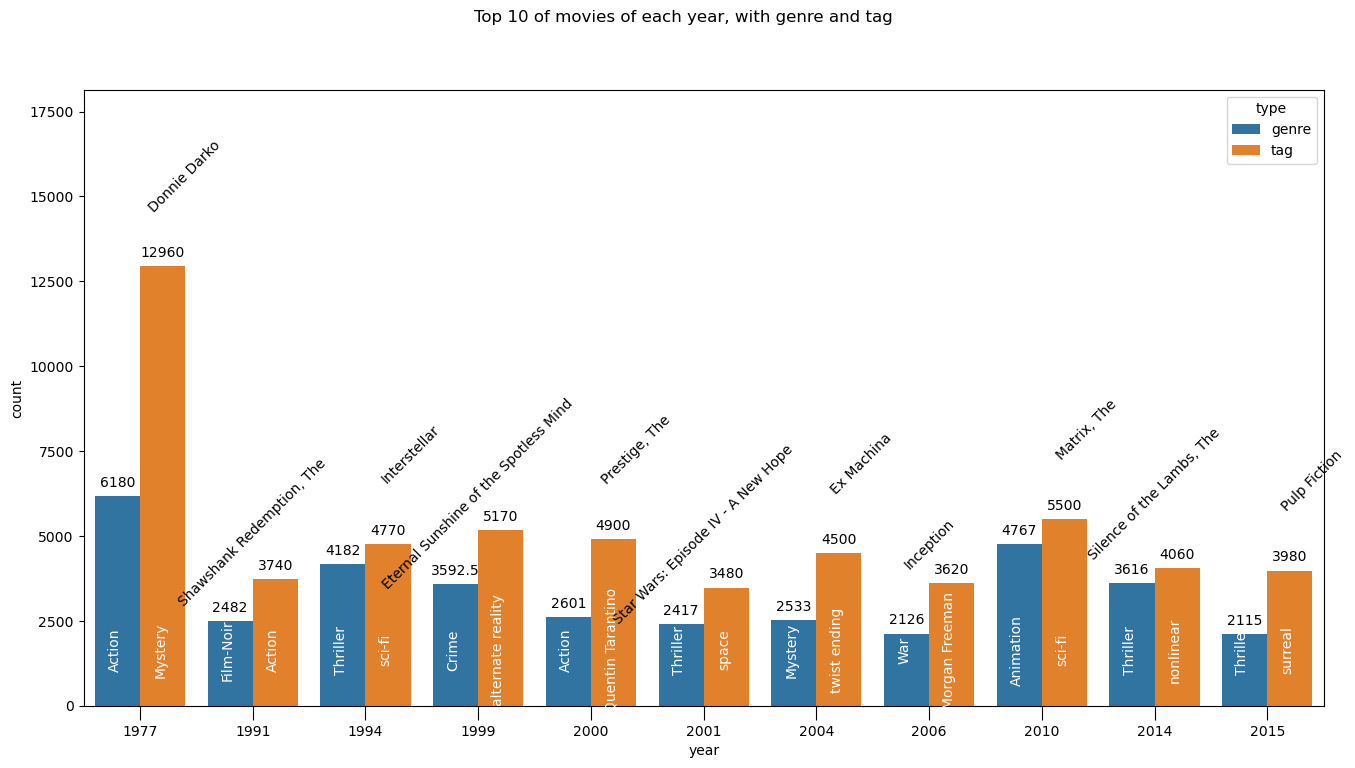

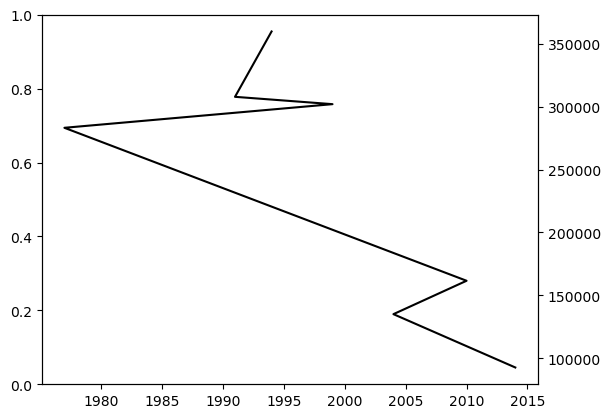

In [86]:
df_p = df_gentag.reset_index()
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize= (16, 8))

my_plot = sns.barplot(x = "year",
           y = "count",
           hue = "type",
           data = df_p,
           errorbar = None)


my_plot.tick_params(labelsize = 10)
my_plot.tick_params(length = 10, axis='x')

heights = {}
for g in my_plot.patches:
    heights[g.get_height()] = g.get_x() + g.get_width() / 2.
    my_plot.annotate(format(g.get_height(), 'g'),
                   (g.get_x() + g.get_width() / 2., g.get_height() + 600),
                   ha = 'center', va = 'center',
                   xytext = (0, -5),
                   textcoords = 'offset points')
            
fig.suptitle('Top 10 of movies of each year, with genre and tag')
plt.ylim(0, 12960*(1.4))

for x, y in df_p.to_dict().items():
    if x == "title":
        titles = list(set(y.values()))
    if x == "class":
        classes =  list(y.values())
        
heights2 = list(heights.keys())[1::2]
titles_h = dict(map(lambda i,j : (i,j) , titles, heights2))

for k, v in titles_h.items():
    my_plot.annotate(k,
                   (heights.get(v)+.2, v + 1000),
                   ha = 'center', va = 'center',
                   xytext = (0, 40),
                   textcoords = 'offset points',
                    horizontalalignment='left',
                    rotation = 45)

classes_h = dict(map(lambda i,j : (i,j) , heights.keys(), classes))

for k, v in classes_h.items():
    my_plot.annotate(v,
                   (heights.get(k)-.02, 10),
                   ha = 'center', va = 'center',
                   xytext = (0, 40),
                   textcoords = 'offset points',
                    horizontalalignment='left',
                    rotation = 90, color = "white")
        

from matplotlib import pyplot as plt
import numpy as np


plt.figure()          
df_p = df_gruped_rate.loc[lambda x: x['movieId'].isin(df_final['movieId'])]
axes2 = plt.twinx()

axes2.plot(df_p["year"], df_p["rating"], color='k', label='Sine')
